# Определение перспективного тарифа для телеком-компании <a id="intro"></a>

«Мегалайн» — федеральный оператор сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.

Требуется сделать предварительный анализ тарифов на небольшой выборке клиентов. Имеются данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Обзор-данных" data-toc-modified-id="Обзор-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Обзор данных</a></span></li><li><span><a href="#Предобработка-данных" data-toc-modified-id="Предобработка-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Предобработка данных</a></span></li><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Анализ данных</a></span><ul class="toc-item"><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Выводы</a></span></li></ul></li><li><span><a href="#Проверка-гипотез" data-toc-modified-id="Проверка-гипотез-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Проверка гипотез</a></span></li><li><span><a href="#Общие-выводы" data-toc-modified-id="Общие-выводы-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общие выводы</a></span></li></ul></div>

## Обзор данных

Подгрузим необходимые библиотеки.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats as st
import warnings
warnings.filterwarnings("ignore")

Прочитаем и изучим имеющиеся данные.

In [2]:
calls = pd.read_csv("calls.csv")
internet = pd.read_csv("internet.csv")
messages = pd.read_csv("messages.csv")
tariffs = pd.read_csv("tariffs.csv")
users = pd.read_csv("users.csv")

In [3]:
data_names = [messages, calls, internet, users]
for data_name in data_names:
    print(data_name.head(), end="\n\n")
    print("-"*76)

       id message_date  user_id
0  1000_0   2018-06-27     1000
1  1000_1   2018-10-08     1000
2  1000_2   2018-08-04     1000
3  1000_3   2018-06-16     1000
4  1000_4   2018-12-05     1000

----------------------------------------------------------------------------
       id   call_date  duration  user_id
0  1000_0  2018-07-25      0.00     1000
1  1000_1  2018-08-17      0.00     1000
2  1000_2  2018-06-11      2.85     1000
3  1000_3  2018-09-21     13.80     1000
4  1000_4  2018-12-15      5.18     1000

----------------------------------------------------------------------------
   Unnamed: 0      id  mb_used session_date  user_id
0           0  1000_0   112.95   2018-11-25     1000
1           1  1000_1  1052.81   2018-09-07     1000
2           2  1000_2  1197.26   2018-06-25     1000
3           3  1000_3   550.27   2018-08-22     1000
4           4  1000_4   302.56   2018-09-24     1000

----------------------------------------------------------------------------
   user_id

In [4]:
data_names = [calls, internet, messages, tariffs, users]
for data_name in data_names:
    print(data_name.info(), end="\n\n")
    print("-"*50)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB
None

--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB
None

---------------------------------------

[В начало](#intro)

## Предобработка данных

Приведем данные в датафреймах к нужным типам там, где это необходимо.

In [5]:
# Таблица с информацией о звонказ
calls["call_date"] = pd.to_datetime(calls["call_date"])
# Таблица с информацией об интернете
internet["session_date"] = pd.to_datetime(internet["session_date"])
# Таблица с информацией об сообщениях
messages["message_date"] = pd.to_datetime(messages["message_date"])

Проверим и устраним артефакты и аномалии в данных.

Удалим столбец, который дублирует индексацию в датафрейме с данными о потреблении интернета.

In [6]:
internet = internet.drop(columns="Unnamed: 0")
internet.head()

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


Проверим датафреймы на дубликаты.

In [7]:
data_names = [calls, internet,messages, users, messages]
for data_name in data_names:
    print(data_name[data_name.duplicated()].count(), end="\n\n")
    print("-"*17)

id           0
call_date    0
duration     0
user_id      0
dtype: int64

-----------------
id              0
mb_used         0
session_date    0
user_id         0
dtype: int64

-----------------
id              0
message_date    0
user_id         0
dtype: int64

-----------------
user_id       0
age           0
churn_date    0
city          0
first_name    0
last_name     0
reg_date      0
tariff        0
dtype: int64

-----------------
id              0
message_date    0
user_id         0
dtype: int64

-----------------


Проверим данные на неотрицательность значений.

In [8]:
calls[calls["duration"] < 0]["duration"].count()

0

In [9]:
internet[internet["mb_used"] < 0]["mb_used"].count()

0

Поменяем название столбца в таблице с информацией о тарифах. Пригодится нам в будущем.

In [10]:
tariffs = tariffs.rename(columns={"tariff_name":"tariff"})
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Избавимся от необязательных столбцов в таблице с информацией о пользователях.

In [11]:
users = users.drop(columns=["churn_date", "first_name", "last_name", "reg_date"])
users.head()

,user_id,age,city,tariff
0,1000,52,Краснодар,ultra
1,1001,41,Москва,smart
2,1002,59,Стерлитамак,smart
3,1003,23,Москва,ultra
4,1004,68,Новокузнецк,ultra


Проверим столбец с информацией о городах на неявные дубликаты.

In [12]:
users["city"].unique()

array(['Краснодар', 'Москва', 'Стерлитамак', 'Новокузнецк',
       'Набережные Челны', 'Ульяновск', 'Челябинск', 'Пермь', 'Тюмень',
       'Самара', 'Санкт-Петербург', 'Иваново', 'Чебоксары', 'Омск', 'Уфа',
       'Томск', 'Чита', 'Мурманск', 'Петрозаводск', 'Тверь',
       'Екатеринбург', 'Махачкала', 'Вологда', 'Череповец', 'Ярославль',
       'Сочи', 'Хабаровск', 'Ставрополь', 'Рязань', 'Улан-Удэ', 'Тула',
       'Саратов', 'Ростов-на-Дону', 'Казань', 'Иркутск', 'Курск',
       'Калуга', 'Якутск', 'Астрахань', 'Химки', 'Владикавказ',
       'Волгоград', 'Саранск', 'Ижевск', 'Новосибирск', 'Брянск',
       'Тольятти', 'Нижний Тагил', 'Орёл', 'Белгород', 'Воронеж',
       'Волжский', 'Курган', 'Барнаул', 'Красноярск', 'Архангельск',
       'Липецк', 'Кемерово', 'Киров', 'Сургут', 'Пенза', 'Магнитогорск',
       'Нижний Новгород', 'Кострома', 'Владивосток', 'Тамбов', 'Балашиха',
       'Севастополь', 'Калининград', 'Оренбург', 'Смоленск',
       'Нижневартовск', 'Владимир', 'Новороссий

[В начало](#intro)

## Анализ данных

Прежде, чем перейти к анализу данных, создадим дополнительные вспомогательные столбцы.

In [13]:
# Дополнительные столбцы - месяцы
calls["month"] = calls["call_date"].dt.month
messages["month"] = messages["message_date"].dt.month
internet["month"] = internet["session_date"].dt.month

Сгуппируем данные по месяцам по каждому пользователю и рассчитаем количество использованных минут, сообщений, интернета по каждому тарифу.

In [14]:
# Группируем данные
messages_per_month = messages.groupby(["user_id","month"])["id"].agg({"count"}).reset_index()
internet_per_month = internet.groupby(["user_id","month"])["mb_used"].agg({"sum"}).reset_index()
call_per_month = calls.groupby(["user_id","month"])["duration"].agg({"sum", "count"}).reset_index()

internet_per_month = internet_per_month.rename(columns={"sum":"internet_usage"})
messages_per_month = messages_per_month.rename(columns={"count":"message_usage"})
call_per_month = call_per_month.rename(columns={"sum":"minutes_usage", "count":"calls_count"})

Объеденим все таблицы в одну единую таблицу.

In [15]:
data = internet_per_month.merge(call_per_month, on=["user_id", "month"],  how="outer")
data = data.merge(messages_per_month, on=["user_id", "month"],  how="outer")
data = users.merge(data, on="user_id", how="right")
data = data.merge(tariffs, on="tariff", how="left")
data.head()

,user_id,age,city,tariff,month,internet_usage,minutes_usage,calls_count,message_usage,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,52,Краснодар,ultra,5,2253.49,150.06,22.0,22.0,1000,30720,3000,1950,150,1,1
1,1000,52,Краснодар,ultra,6,23233.77,158.90,43.0,60.0,1000,30720,3000,1950,150,1,1
2,1000,52,Краснодар,ultra,7,14003.64,318.80,47.0,75.0,1000,30720,3000,1950,150,1,1
3,1000,52,Краснодар,ultra,8,14055.93,389.87,52.0,81.0,1000,30720,3000,1950,150,1,1
4,1000,52,Краснодар,ultra,9,14568.91,440.14,58.0,57.0,1000,30720,3000,1950,150,1,1


Создадим функцию для расчета общей выручки с каждого пользователя с учетом трат на дополнительные минуты, сообщения, интернет по каждому тарифу.

In [16]:
def total_revenue(row):
    
    revenue_per_extra_messages = 0 
    revenue_per_extra_internet = 0
    revenue_per_extra_minutes = 0
    
    message_usage = row["message_usage"]
    internet_usage = row["internet_usage"]
    minutes_usage = row["minutes_usage"]
    
    messages_included = row["messages_included"]
    mb_per_month_included = row["mb_per_month_included"]
    minutes_included = row["minutes_included"]
    
    rub_per_message = row["rub_per_message"]
    rub_per_gb = row["rub_per_gb"]
    rub_per_minute = row["rub_per_minute"]
    
    rub_monthly_fee = row["rub_monthly_fee"]
    tariff = row["tariff"]
    
    if message_usage > messages_included:
        revenue_per_extra_messages += (message_usage - messages_included) * rub_per_message
    if message_usage < messages_included:    
        revenue_per_extra_messages = 0
    if internet_usage > mb_per_month_included:
        revenue_per_extra_internet += np.ceil((internet_usage - mb_per_month_included)/1024) * rub_per_gb
    if internet_usage < mb_per_month_included:
        revenue_per_extra_internet = 0
    if minutes_usage > minutes_included:
        revenue_per_extra_minutes += np.ceil((minutes_usage - minutes_included)) * rub_per_minute
    if minutes_usage < minutes_included:
        revenue_per_extra_minutes = 0
    
    return rub_monthly_fee + revenue_per_extra_messages + revenue_per_extra_internet + revenue_per_extra_minutes

Применим нашу функцию.

In [17]:
data["total_revenue"] = data.apply(total_revenue, axis=1)

Избавимся от уже не нужных столбцов.

In [18]:
data = data[["user_id", "age", "city", "tariff", "month", "internet_usage",
       "minutes_usage", "calls_count", "message_usage","total_revenue"]]
data.head()

,user_id,age,city,tariff,month,internet_usage,minutes_usage,calls_count,message_usage,total_revenue
0,1000,52,Краснодар,ultra,5,2253.49,150.06,22.0,22.0,1950.0
1,1000,52,Краснодар,ultra,6,23233.77,158.90,43.0,60.0,1950.0
2,1000,52,Краснодар,ultra,7,14003.64,318.80,47.0,75.0,1950.0
3,1000,52,Краснодар,ultra,8,14055.93,389.87,52.0,81.0,1950.0
4,1000,52,Краснодар,ultra,9,14568.91,440.14,58.0,57.0,1950.0


Перейдем к непосредственно анализу. 

Сколько всего пользователей по каждому тарифу?

In [19]:
smart = data["tariff"].value_counts()[0]/data["tariff"].value_counts().sum() * 100
ultra = 100 - smart
print(f"Доля пользователей с тарифом Smart составляет: {smart: .2f}")
print(f"Доля пользователей с тарифом Ultra составляет: {ultra: .2f}")

Доля пользователей с тарифом Smart составляет:  69.35
Доля пользователей с тарифом Ultra составляет:  30.65


Около 70% пользователей из выборки пользуются более бюджетным тарифом.

Рассчитаем среднюю, дисперсию и стандартное отклонение по каждой составляющей обеих тарифов. 

In [20]:
dist_stat = data.groupby(["tariff"])[["minutes_usage", 
                                      "message_usage", 
                                      "internet_usage"]].agg({"minutes_usage": [np.mean, np.var, np.std], 
                                                              "message_usage": [np.mean, np.var, np.std], 
                                                              "internet_usage": [np.mean, np.var, np.std]})
dist_stat

minutes_usage                           message_usage               \
                mean           var         std          mean          var   
tariff                                                                      
smart     395.491606  32052.625911  179.032472     38.716441   717.594201   
ultra     514.839327  84002.601260  289.832022     61.161006  2109.659183   

                  internet_usage                             
              std           mean           var          std  
tariff                                                       
smart   26.787949   16215.661849  3.435995e+07  5861.736234  
ultra   45.931026   19668.485262  9.886425e+07  9943.050284

В среднем по всем компонентам тарифов больше потребляют пользователи по тарифу Ultra, но и рассеясние соотвественно больше, среди основных причин которого можно выделить:
- относительно меньшая выборка наблюдений по тарифу Ultra по сравнению с выборкой Smart. Напомним, что около 70% пользователей общей выборки приходятся на Smart;
- предоположительно разное поведение пользователей тарифов Ultra и Smart. Пльзователи тарифа Smart стараются уложиться в выделенный пакет и в большинстве случаев им это удается, однако, некоторые пользователи все же не укладываются в пакет и потребляют больше, чем положено по тарифу. В тоже время у пользователей тарифа Ultra на старте доступны большие объемы, даже при самом активном пользовании услугами, сложно представить перерасход по данному тарифу, а значит большинство пользователей вовсе не ограничивают себя, в отличие от пользователей тарифа Smart, где имеющегося пакета с натяжкой хватает под конец месяца.

Визуализируем распределения потребления пользователями пакетов Smart и Ultra.

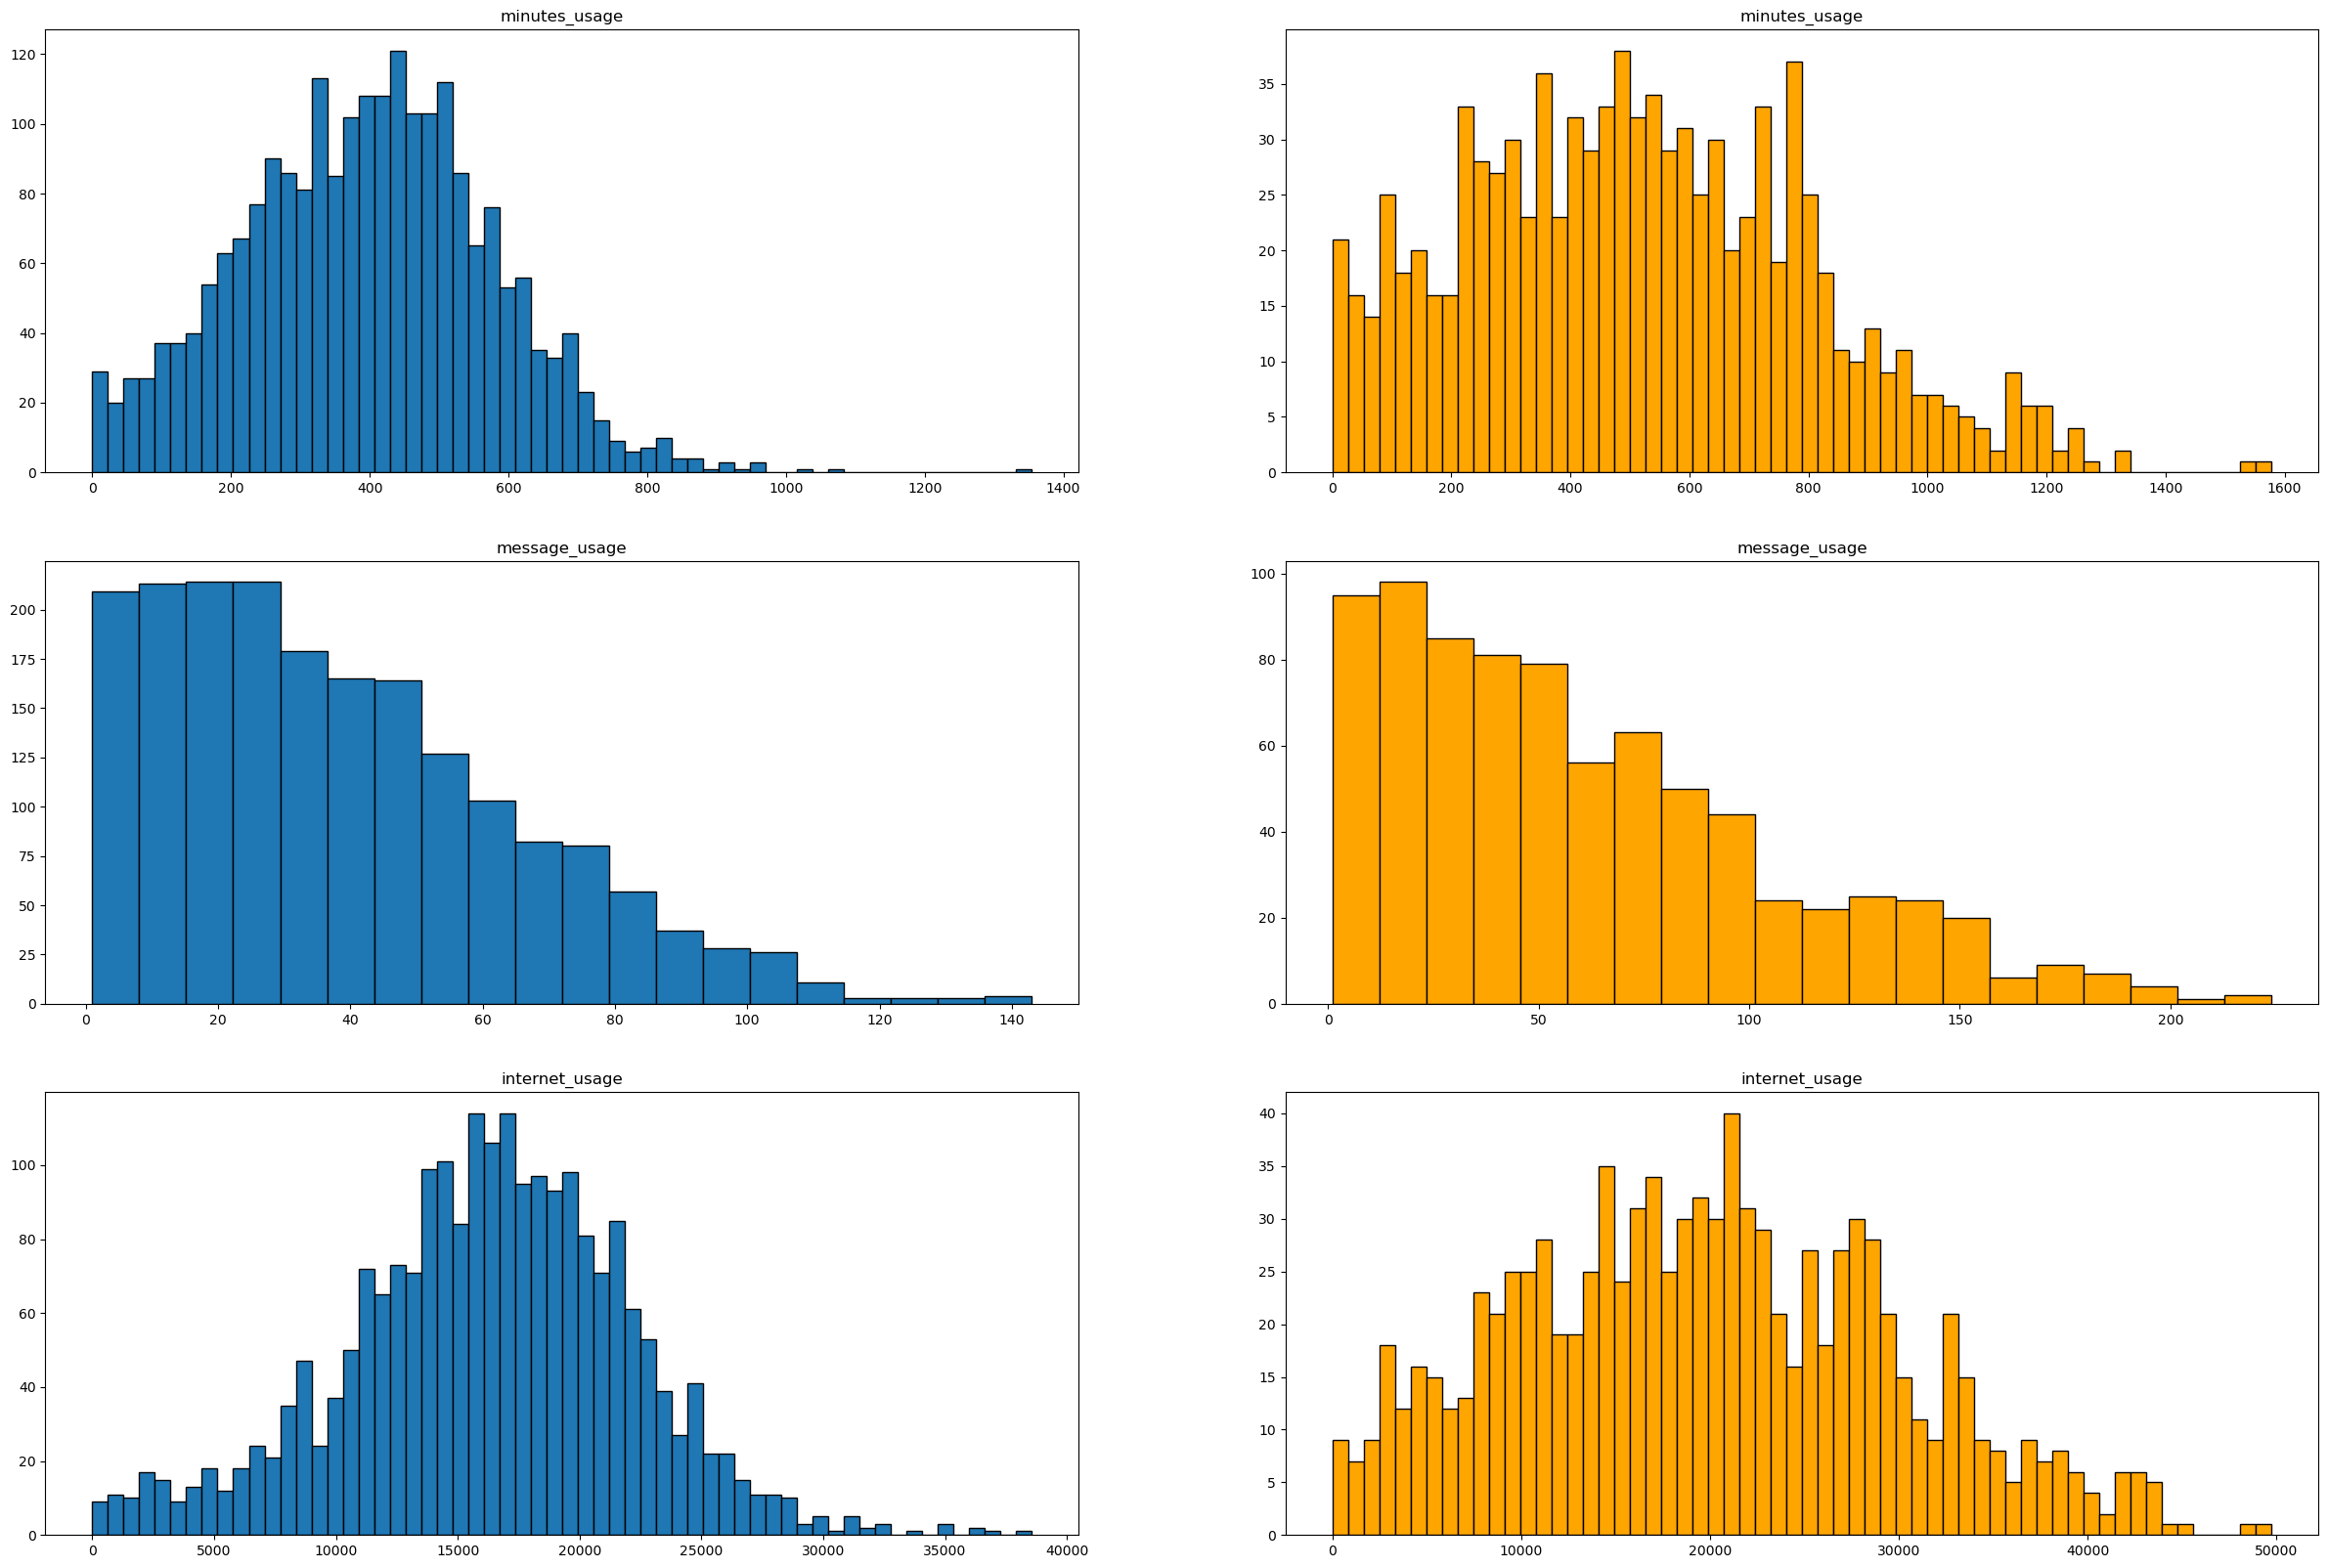

In [21]:
plt.figure(figsize=(30, 20))

columns = ["minutes_usage", "message_usage", "internet_usage"]

k = 1

for column in columns:
    
    if column == "minutes_usage":
        bins = 40
    if column == "message_usage":
        bins = 20
    else:
        bins = 60
    
    plt.subplot((len(columns)), 2, k)
    plt.hist(data[data["tariff"] == "smart"][column], ec="black", bins=bins)
    plt.title(column)
    
    plt.subplot((len(columns)), 2, k+1)
    plt.hist(data[data["tariff"] == "ultra"][column], color="orange", ec="black", bins=bins)
    plt.title(column)
    
    k+=2

### Выводы

Как и было упомянуто выше по тарифу Ultra разброс больше, видны отдельные пики, присутствует шум, в то время как данные по тарифу Smart c меньшим шумом и единичными пиками. Несмотря на это можно сказать, что потребление обеих тарифов стремится к нормальному распределению. 
* Визуально пик на тарифе смарт стремится к 400 минутам, среднестатистический пользователь тарифа Smart тратит именно столько минут, большинство же пользователей тратят от 200 до 400 минут в месяц. Пик по тарифу Ultra приходится на 500 минутах, большинство пользователей тратят 200 до 800 минут в месяц на разговоры по сотовой связи. Стоит также заметить, что это все звонки совершенные по сотовой связи. В текущих реалиях не малая часть звонков приходятся на звонки в соц сетях и месенджерах по интернет связи, кроме того, большинство тарифов поддерживают использование мессенджерами даже при отрицательном балансе. Что это может значить? Это может означать то, что часть звонков покрываются месенджерами и тем сам не тратятся минуты основного пакета, что пользователям на руку. При лимите в 500 минут значительное число пользователей тратят больше, следовательно платят за перерасход, на тарифе ультра имеются единичные случаи перерасхода по тарифу. Нули в столбцах это пропущенные звонки;
* Большинство пользователей тарифа Smart отправляют в месяц от 0 до 80 сообщений, на тарифе Ultra от 0 до 100, разрброс сильнее на последнем, пик у обоих тарифов около 20 сообщений в месяц. Многие пользователи вообще не отправляли сообщения. В современном мире редко отправляются сообщения по номеру телефона, абсолютное большинство пользователей общаются в месенджерах, но тем менее виден очевидный перерасход при лимите в 50 сообщений в месяц по тарифу Smart. По тарифу Ultra перерасходов по сообщениям нет, ввиду больншого лимита в 1000 сообщений;
* На тарифе Smart в среднем потребляются 16-17 гб, большинство потребляют 10 до 23 гб при лимите порядка 15 гб. На тарифе Ultra наблюдается сильный разраброс, но в целом большинство тратят от 8 до 30 гб, пик на уровне 22 гб. Интернет это единственное, где у пользователей тарифа Ultra бывают перерасходы.

[В начало](#intro)

## Проверка гипотез

Переходим к основным интересующим вопросам в исследовании. 

**Первая гипотеза**, которую нужно проверить - средняя выручка пользователей тарифов «Ультра» и «Смарт» различается.

Сформулируем нулевую и альтернативную гипотезы:
- H0: Средняя выручка пользователей тарифов «Ультра» и «Смарт» равны
- Н1: Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются

In [22]:
# При уровне значимости в 5%
smart = data[data["tariff"] == "smart"]["total_revenue"]
ultra = data[data["tariff"] == "ultra"]["total_revenue"]

alpha = .05

results = st.ttest_ind(smart, ultra, equal_var=False)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 6.179723168444486e-274
Отвергаем нулевую гипотезу


pvalue слишком мал, значительно ниже определенного нами уровня значимости в 5%. Проверим результат гипотезы при снижении уровня значимости до 1%.

In [23]:
# При уровне значимости в 1%
smart = data[data["tariff"] == "smart"]["total_revenue"]
ultra = data[data["tariff"] == "ultra"]["total_revenue"]

alpha = .01

results = st.ttest_ind(smart, ultra, equal_var=False)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 6.179723168444486e-274
Отвергаем нулевую гипотезу


Разница между средними выручки по тарифам сильно большая, чтобы считать это случайностью, а значит они не равны.

In [24]:
smart.mean()

1257.5886047554957

In [25]:
ultra.mean()

2070.1522842639592

Видно, что средняя выручка по тарифам сильно разнятся, по тарифу Smart в среднем переплата сильно большая, по тарифу  Ultra средняя выручка немного завышена за счет отдельных активных пользователей.

**Вторая гипотеза**, которую нужно проверить - средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов.

Сформулируем нулевую и альтернативную гипотезы:
- Н0: Средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов
- Н1: Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

In [26]:
# При уровне значимости в 5%
moscow = data[data["city"] == "Москва"]["total_revenue"]
other_cities = data[data["city"] != "Москва"]["total_revenue"]
alpha = .05

results = st.ttest_ind(moscow, other_cities, equal_var=False)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.46532858228722906
Не получилось отвергнуть нулевую гипотезу


Разница между средними выручки по городам незначительная, то есть статистически незначима, а значит они равны.

[В начало](#intro)

## Общие выводы

По итогам статистического анализа было установлено:
- телеком-компания "Мегалайн" в среднем получает больше доходов с одного пользователя на тарифе Ultra (2070 руб.), чем на тарифе Smart (1258 руб.);
- пользователи Smart в среднем доплачивают 700 руб. (1278-550 | 232%) в виду нехватки пакета минут, сообщений и интернета, в то время как в среднем пакет минут, сообщений и интернета пользователям тарифа Ultra хватает (не используется в полном объеме);
- разница доходов компании по тарифам в разных городах и в Москве статически незначима.
Следствие:
- больше доходов компания получает именно на тарифе Ultra, поэтому при составлении рекламной компании стоит учитывать этот фактор;
- компания получает одинковые доходы в среднем на каждом из тарифов по разным городам, то есть рекламную компанию можно запускать в любом из регионов страны.

[В начало](#intro)